<a href="https://colab.research.google.com/github/aaroncdvd/HRBS-CA_Python_AI/blob/main/PredictDiabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can we use an ML model with the diabetes patient data?

![](https://miro.medium.com/max/2066/1*wWRGcsBwoXw-WNJi5UpoOw.png)

##Preparing your data!

*Create SQL Database*

![](https://hackr.io/blog/sql-cheat-sheet/thumbnail/large)

In [ ]:
!apt-get install sqlite3 # Install SQLite

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 752 kB of archives.
After this operation, 2,482 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 sqlite3 amd64 3.22.0-1ubuntu0.4 [752 kB]
Fetched 752 kB in 1s (698 kB/s)
Selecting previously unselected package sqlite3.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../sqlite3_3.22.0-1ubuntu0.4_amd64.deb ...
Unpacking sqlite3 (3.22.0-1ubuntu0.4) ...
Setting up sqlite3 (3.22.0-1ubuntu0.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
![ -e diabetes.csv.db ] && rm diabetes.csv.db # Remove Existing SQL Files and Load New SQL From CSV
!wget -O - -o /dev/null 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'|sqlite3 -csv diabetes.csv.db ".import /dev/stdin diabetes_csv"

In [ ]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

diabetes_csv


*Query Diabetes.csv using SQL*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select rowid,* from diabetes_csv limit 1"

rowid       Pregnancies  Glucose     BloodPressure  SkinThickness  Insulin     BMI         DiabetesPedigreeFunction  Age         Outcome   
----------  -----------  ----------  -------------  -------------  ----------  ----------  ------------------------  ----------  ----------
1           6            148         72             35             0           33.6        0.627                     50          1         


##Exercise: Let's find Average BMI for patients with and without diabetes!

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select Outcome,avg(BMI) from diabetes_csv group by Outcome"

Outcome     avg(BMI)  
----------  ----------
0           30.3042   
1           35.1425373


*Make it Pretty!*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select case when Outcome=0 then 'no diabetes' else 'diabetes' end as Outcome,avg(BMI) AveraveBMI from diabetes_csv group by Outcome"

Outcome      AveraveBMI
-----------  ----------
no diabetes  30.3042   
diabetes     35.1425373


*Save the results as a Virtual Table: Average_BMI*

In [ ]:
!sqlite3 diabetes.csv.db "drop view if exists average_bmi; create view average_bmi as \
select case when Outcome=0 then 'no diabetes' else 'diabetes' end as Outcome,avg(BMI) AverageBMI from diabetes_csv group by Outcome"

In [ ]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

average_bmi   diabetes_csv  diabetes_ml 


*Query Virtual Table*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select * from average_BMI"

Outcome      avg(BMI)  
-----------  ----------
no diabetes  30.3042   
diabetes     35.1425373


## Load Data to Python

*Import SQL to Pandas*

In [ ]:
import pandas as pd # Import Pandas
import sqlite3 # Import SQL

In [ ]:
sqlite = sqlite3.connect("diabetes.csv.db") # Connect to Diabetes

In [ ]:
diabetes_df = pd.read_sql_query("select * from diabetes_csv",sqlite) # Load SQL to Pandas
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.34,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
diabetesX=diabetes_df[diabetes_df.columns[:8]]

In [ ]:
diabetesY=diabetes_df[diabetes_df.columns[8:]]

## [>](https://datascienceplus.com/machine-learning-for-diabetes-with-python/) Do Machine Learning!

*Split into Test and Training*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(diabetesX), diabetesY, test_size=0.1, random_state=42)

*Predict Diabetes Using ML Model*

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.776
Test set score: 0.701


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*Plot Weight Matrix*

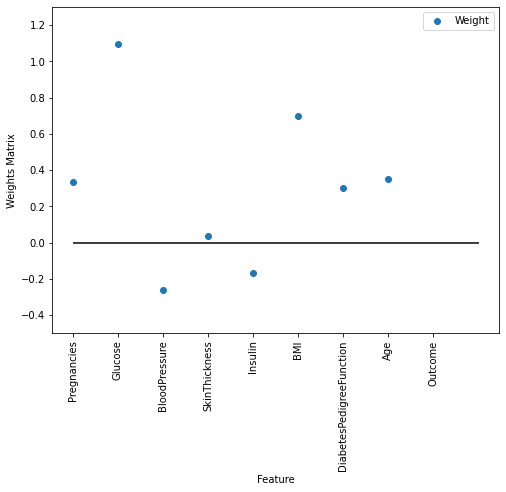

In [ ]:
import matplotlib.pyplot as plt
diabetes_features = [x for i,x in enumerate(diabetes_df.columns)]
plt.figure(figsize=(8,6))
plt.plot(logreg.coef_.T, 'o', label="Weight")
plt.xticks(range(diabetes_df.shape[1]), diabetes_features, rotation=90)
plt.hlines(0, 0, diabetes_df.shape[1])
plt.ylim(-.5, 1.3)
plt.xlabel("Feature")
plt.ylabel("Weights Matrix")
plt.legend()

### How do we use this and what does it mean?

LARGER numbers mean MORE important to predict the Outcome! In this example, Glucose and BMI seem to be the MOST IMPORTANT to predict diabetes in patients!

## [>](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a) Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
predictions = logreg.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[36 14]
 [ 9 18]]


Text(0.5, 1.7999999999999972, 'Predicted label')

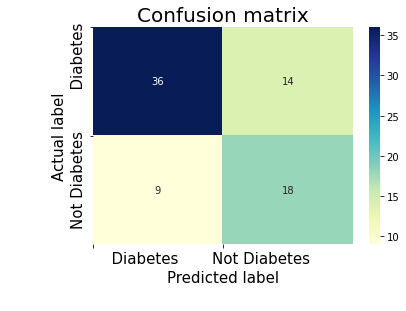

In [ ]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["                      Diabetes", "                Not Diabetes"], size = 15)
plt.yticks(tick_marks, ["                      Diabetes", "                Not Diabetes"], size = 15)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, size = 20)
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)

## What's missing from our model?

The ML model has more information than just 'Diabetes' and 'Not Diabetes' but a number between 0 and 1! What could we use this for? Could we make a risk score using this as a percentage likelihood that the patient has diabetes rather than simply saying 'Diabetes' and 'Not Diabetes'?

## Save the Results

*Save Weights in SQL Database*

In [ ]:
diabetes_ml["weight"] = pd.DataFrame(logreg.coef_.T) # Export Weight Matrix

In [ ]:
diabetes_ml["variable"] = pd.DataFrame(diabetes_features) # Include Column Names
diabetes_ml

,0,variable,weight
0,0.335147,Pregnancies,0.335147
1,1.095746,Glucose,1.095746
2,-0.261345,BloodPressure,-0.261345
3,0.034341,SkinThickness,0.034341
4,-0.168987,Insulin,-0.168987
5,0.699556,BMI,0.699556
6,0.300003,DiabetesPedigreeFunction,0.300003
7,0.349094,Age,0.349094


In [ ]:
diabetes_ml.to_sql("diabetes_ml",sqlite, if_exists="replace") # Save Pandas Dataframe to SQL

In [ ]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

average_bmi   diabetes_csv  diabetes_ml 


*Make a Report of the Weights by Importance*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select variable,round(weight,1) as weight from diabetes_ml order by weight desc"

variable    weight    
----------  ----------
Glucose     1.1       
BMI         0.7       
Pregnancie  0.3       
DiabetesPe  0.3       
Age         0.3       
SkinThickn  0.0       
Insulin     -0.2      
BloodPress  -0.3      


In [ ]:
sqlite.close() # Disconnect from SQL